# Data Exploration of InsideAirbnb.com listings for NY and London


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
from rnd.domain.poc.city import AvailableCity
from rnd.rbnb.data_provider import load_rbnb_listing_data

ny_data = load_rbnb_listing_data(AvailableCity.NEW_YORK)
london_data = load_rbnb_listing_data(AvailableCity.LONDON)


In [28]:
# New York
print("\nNew York Listings - Info:")
print(ny_data.info())



New York Listings - Info:
<class 'pandas.core.frame.DataFrame'>
Index: 37782 entries, 0 to 37783
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      37782 non-null  int64  
 1   listing_url             37782 non-null  object 
 2   name                    37782 non-null  object 
 3   description             36809 non-null  object 
 4   host_id                 37782 non-null  int64  
 5   host_is_superhost       37782 non-null  bool   
 6   neighbourhood_cleansed  37782 non-null  object 
 7   latitude                37782 non-null  float64
 8   longitude               37782 non-null  float64
 9   property_type           37782 non-null  object 
 10  room_type               37782 non-null  object 
 11  accommodates            37782 non-null  int64  
 12  bathrooms               22985 non-null  float64
 13  bedrooms                31974 non-null  float64
 14  beds            

In [29]:
print("\nLondon Listings - Info:")
print(london_data.info())


London Listings - Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95144 entries, 0 to 95143
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      95144 non-null  int64  
 1   listing_url             95144 non-null  object 
 2   name                    95144 non-null  object 
 3   description             92196 non-null  object 
 4   host_id                 95144 non-null  int64  
 5   host_is_superhost       95144 non-null  bool   
 6   neighbourhood_cleansed  95144 non-null  object 
 7   latitude                95144 non-null  float64
 8   longitude               95144 non-null  float64
 9   property_type           95144 non-null  object 
 10  room_type               95144 non-null  object 
 11  accommodates            95144 non-null  int64  
 12  bathrooms               62744 non-null  float64
 13  bedrooms                82794 non-null  float64
 14  beds         

In [30]:
all_listings = pd.concat([ny_data, london_data], ignore_index=True)
all_listings['data_status'] = all_listings.notna().all(axis=1).map({True: 'Complete', False: 'Incomplete'})


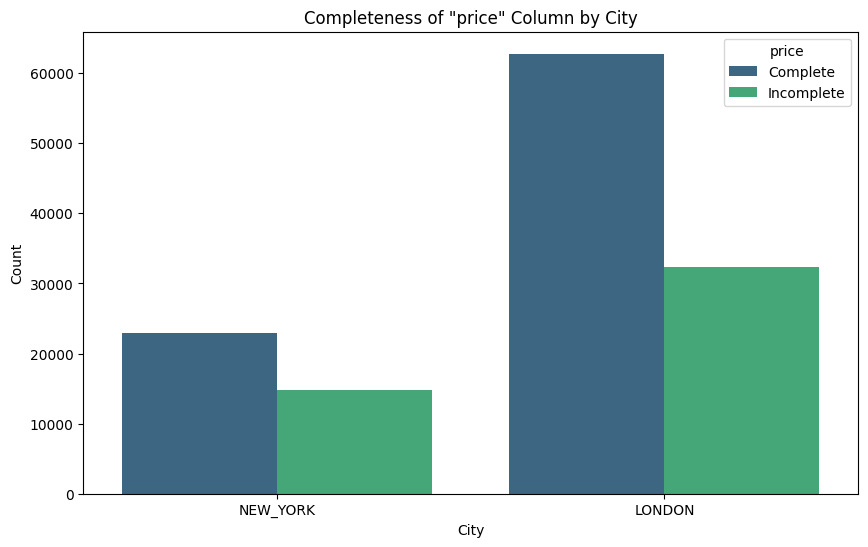

In [31]:
plt.figure(figsize=(10, 6))

sns.countplot(
    data=all_listings,
    x='city',
    hue=all_listings['price'].isna().map({True: 'Incomplete', False: 'Complete'}),
    palette='viridis'
)

plt.xlabel('City')
plt.ylabel('Count')
plt.title('Completeness of "price" Column by City')
plt.show()


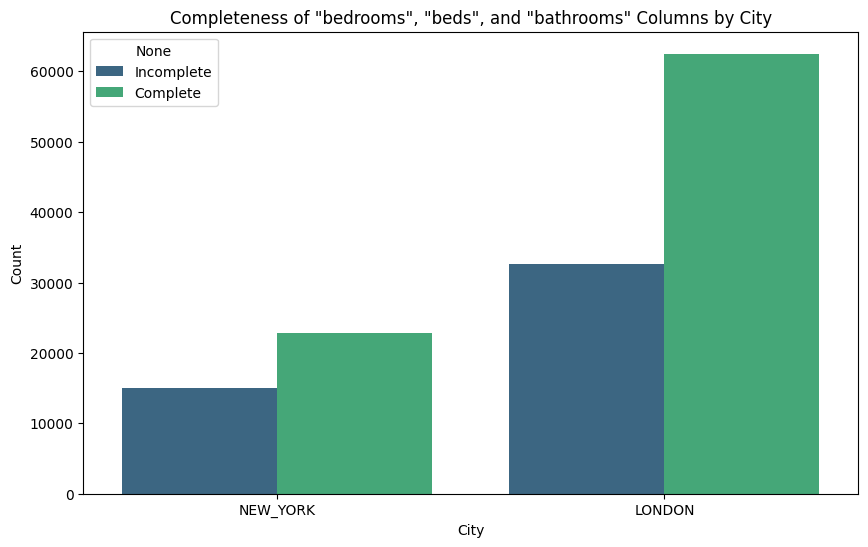

In [32]:
missing_bed_data = all_listings[['bedrooms', 'beds', 'bathrooms']].isna().any(axis=1)

plt.figure(figsize=(10, 6))

sns.countplot(
    data=all_listings,
    x='city',
    hue=missing_bed_data.map({True: 'Incomplete', False: 'Complete'}),
    palette='viridis'
)

plt.xlabel('City')
plt.ylabel('Count')
plt.title('Completeness of "bedrooms", "beds", and "bathrooms" Columns by City')
plt.show()


       city  count  nan_count        mean  median  min      max         std
0    LONDON  62777      32367  207.141581   134.0  1.0  80000.0  774.707797
1  NEW_YORK  22969      14813  195.224128   132.0  8.0  20000.0  353.251037


/var/folders/qt/z4grrnl54m18jsyt2pvlxy5m0000gn/T/ipykernel_31344/3518765710.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


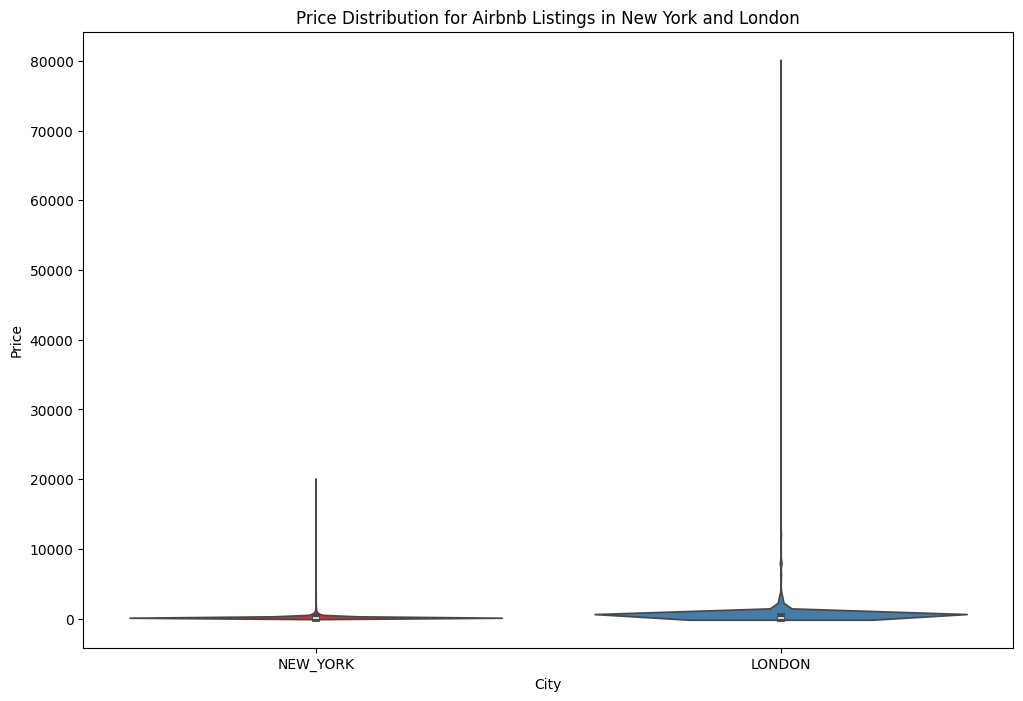

In [33]:
price_summary = all_listings.groupby('city')['price'].agg(
    count='count',
    nan_count=lambda x: x.isna().sum(),
    mean='mean',
    median='median',
    min='min',
    max='max',
    std='std'
).reset_index()
print(price_summary)



plt.figure(figsize=(12, 8))

sns.violinplot(
    data=all_listings,
    x='city',
    y='price',
    palette='Set1'
)

plt.xlabel('City')
plt.ylabel('Price')
plt.title('Price Distribution for Airbnb Listings in New York and London')

plt.show()


       city  count  nan_count        mean  median  min    max        std
0    LONDON  58480          0  144.559439   125.0  1.0  422.0  87.720125
1  NEW_YORK  21505          0  147.709509   125.0  8.0  422.0  88.972629


/var/folders/qt/z4grrnl54m18jsyt2pvlxy5m0000gn/T/ipykernel_31344/860953171.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


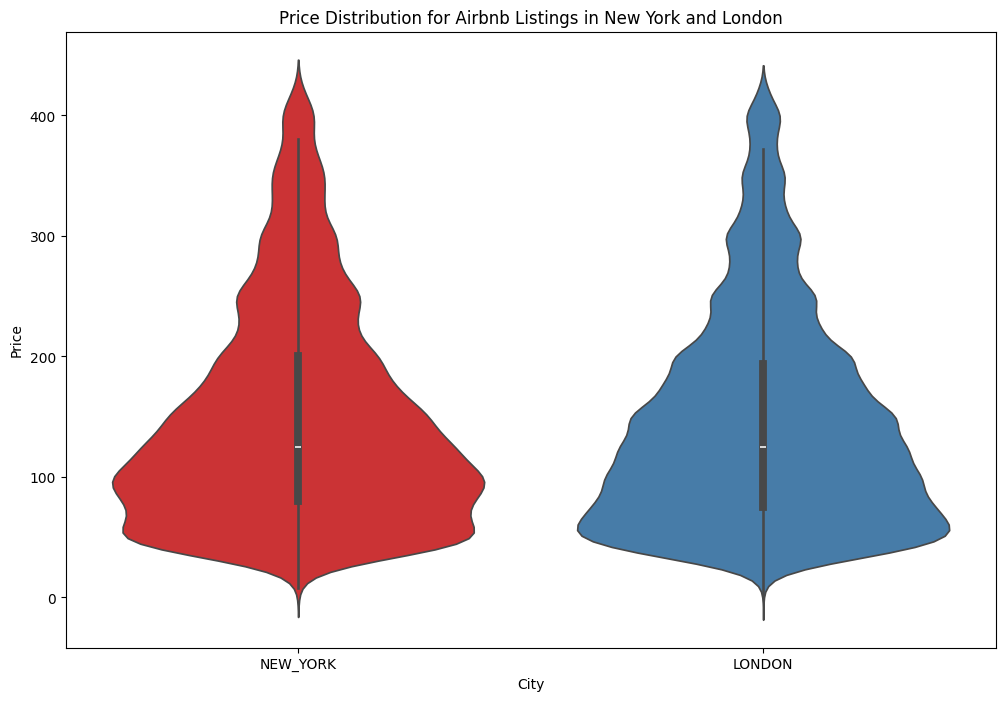

In [34]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

cleaned_listings = remove_outliers(all_listings, 'price')
price_summary = cleaned_listings.groupby('city')['price'].agg(
    count='count',
    nan_count=lambda x: x.isna().sum(),
    mean='mean',
    median='median',
    min='min',
    max='max',
    std='std'
).reset_index()
print(price_summary)

plt.figure(figsize=(12, 8))

sns.violinplot(
    data=cleaned_listings,
    x='city',
    y='price',
    palette='Set1'
)

plt.xlabel('City')
plt.ylabel('Price')
plt.title('Price Distribution for Airbnb Listings in New York and London')

plt.show()



In [35]:
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

def plot_map_with_price(df, city_name):
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(column='price', cmap='viridis', legend=True, markersize=0.5, alpha=0.3, ax=ax)
    ctx.add_basemap(ax, crs=gdf.crs)

    plt.title(f'Property Prices by Location in {city_name}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


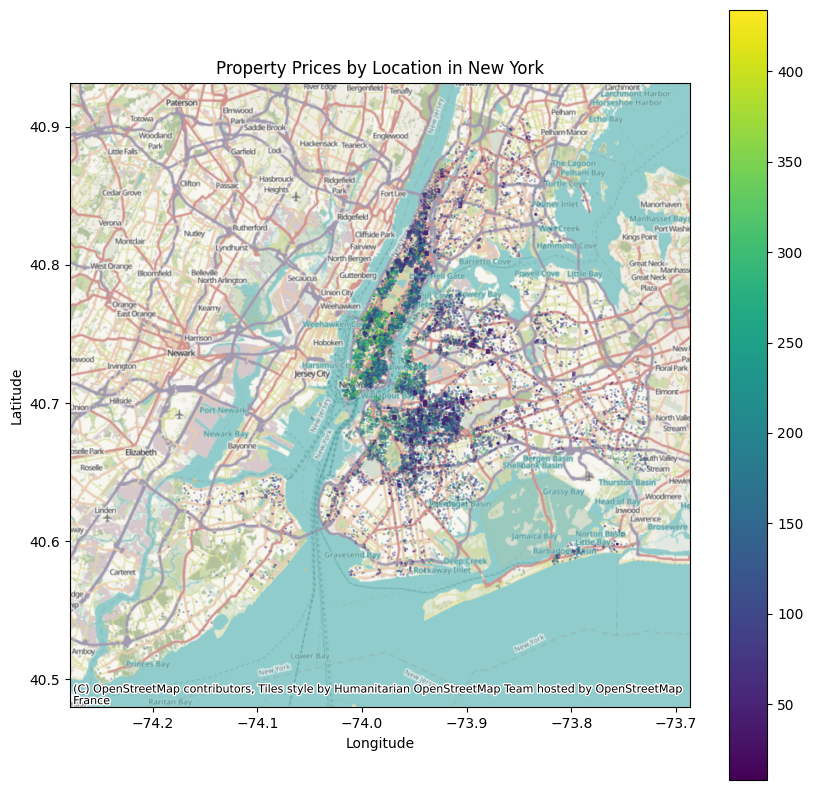

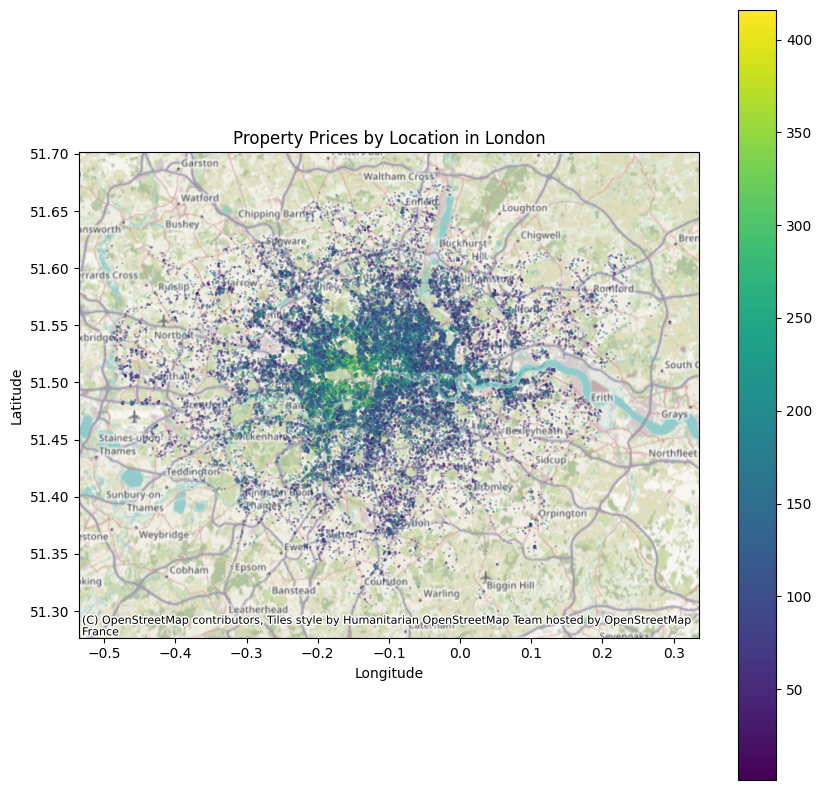

In [36]:
plot_map_with_price(remove_outliers(ny_data, 'price'), 'New York')
plot_map_with_price(remove_outliers(london_data, 'price'), 'London')


In [42]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def preprocess_and_train(df, target_col="price"):
    df = df.copy()

    df.columns = df.columns.str.strip().str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)
    df.columns = df.columns.str.replace(r"__+", "_", regex=True)  # Replace multiple underscores
    df.columns = df.columns.str.strip("_")  # Remove leading/trailing underscores
    
    # Convert categorical variables
    categorical_cols = df.select_dtypes(include=["object", "bool"]).columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    df.columns = df.columns.str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)

    def make_unique(column_names):
        seen = {}
        unique_names = []
        for col in column_names:
            if col in seen:
                seen[col] += 1
                unique_names.append(f"{col}_{seen[col]}")
            else:
                seen[col] = 0
                unique_names.append(col)
        return unique_names

    df.columns = make_unique(df.columns)

    # Split data
    X = df.drop(columns=[target_col, "id", "listing_url", "name", "description", "city"], errors='ignore')
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train LightGBM model
    model = lgb.LGBMRegressor(num_boost_round=100, verbose=1)
    model.fit(X_train, y_train)  # Validation set for logging

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation
    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2 Score": r2_score(y_test, y_pred)
    }

    return model, metrics

In [ ]:
# import lightgbm as lgb
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# def preprocess_and_train(df, target_col="price"):
#     df = df.copy()

#     # Clean column names: remove spaces and special characters
#     df.columns = df.columns.str.strip().str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)
#     df.columns = df.columns.str.replace(r"__+", "_", regex=True)  # Replace multiple underscores
#     df.columns = df.columns.str.strip("_")  # Remove leading/trailing underscores

#     # Convert categorical variables to one-hot encoding
#     categorical_cols = df.select_dtypes(include=["object", "bool"]).columns
#     df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

#     df.columns = df.columns.str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)

#     def make_unique(column_names):
#         seen = {}
#         unique_names = []
#         for col in column_names:
#             if col in seen:
#                 seen[col] += 1
#                 unique_names.append(f"{col}_{seen[col]}")
#             else:
#                 seen[col] = 0
#                 unique_names.append(col)
#         return unique_names

#     df.columns = make_unique(df.columns)
#     print(df.columns)

#     # Split data into features and target
#     X = df.drop(columns=[target_col, "id", "listing_url", "name", "description", "city"], errors='ignore')
#     y = df[target_col]

#     # Sample only 100 rows for quick validation
#     X_sample, y_sample = X.iloc[:100], y.iloc[:100]

#     X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

#     # Train LightGBM model
#     model = lgb.LGBMRegressor(n_estimators=100, verbose=1)
#     model.fit(X_train, y_train)

#     # Predictions
#     y_pred = model.predict(X_test)

#     # Evaluation metrics
#     metrics = {
#         "MAE": mean_absolute_error(y_test, y_pred),
#         "MSE": mean_squared_error(y_test, y_pred),
#         "R2 Score": r2_score(y_test, y_pred)
#     }

#     return model, metrics

In [43]:
df_price_cleaned = ny_data.dropna(subset=['price'])
display(df_price_cleaned)
model_price_cleaned, metrics_price_cleaned = preprocess_and_train(df_price_cleaned)
print("Metrics for dataset with missing price removed:", metrics_price_cleaned)

,id,listing_url,name,description,host_id,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,...,bathrooms,bedrooms,beds,price,availability_365,number_of_reviews,review_scores_rating,instant_bookable,reviews_per_month,city
0,39572,https://www.airbnb.com/rooms/39572,1 br in a 2 br apt (Midtown West),NaN,169927,False,Hell's Kitchen,40.76203,-73.98869,Private room in rental unit,...,NaN,1.0,1.0,139.0,365,44,4.86,False,0.25,NEW_YORK
1,39593,https://www.airbnb.com/rooms/39593,A lovely room w/ a Manhattan view,"A private, furnished large room to rent Jan/F...",110506,False,Sunnyside,40.74523,-73.92318,Private room in condo,...,1.0,1.0,1.0,78.0,248,34,4.93,False,0.20,NEW_YORK
3,42300,https://www.airbnb.com/rooms/42300,Beautiful Lower East Side Loft,Architect-owned loft is a corner unit in a bea...,184755,False,Lower East Side,40.71992,-73.99167,Entire loft,...,2.0,3.0,4.0,750.0,87,70,4.80,False,0.40,NEW_YORK
4,42729,https://www.airbnb.com/rooms/42729,@HouseOnHenrySt - Private 2nd bedroom w/shared...,NaN,11481,False,Carroll Gardens,40.67813,-74.00062,Private room in townhouse,...,1.0,1.0,1.0,185.0,364,220,4.66,False,1.26,NEW_YORK
5,43105,https://www.airbnb.com/rooms/43105,Studio 3 blocks from Empire State Building,"In the NoMad neighborhood, a few blocks north ...",188082,False,Midtown,40.74490,-73.98499,Entire rental unit,...,1.0,1.0,1.0,165.0,365,4,5.00,False,0.04,NEW_YORK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37779,1322024128476576885,https://www.airbnb.com/rooms/1322024128476576885,"The Gem of Riverdale, NYC!",Visiting NYC and looking for a place to stay? ...,35391290,False,Kingsbridge,40.88178,-73.89973,Entire place,...,1.0,1.0,1.0,159.0,365,0,NaN,False,NaN,NEW_YORK
37780,1322305006441883773,https://www.airbnb.com/rooms/1322305006441883773,Amazing 1BR & 1BTH,"This special place is close to everything, mak...",504878421,False,Financial District,40.70610,-74.00666,Entire rental unit,...,1.0,1.0,1.0,199.0,306,0,NaN,False,NaN,NEW_YORK
37781,1322523395081457963,https://www.airbnb.com/rooms/1322523395081457963,Home Share w/ Young Professionals - 2/3/4/5 Tr...,"Sun-filled, fully furnished apartment located ...",2822805,True,Crown Heights,40.67013,-73.95874,Private room in rental unit,...,2.0,1.0,1.0,99.0,65,0,NaN,False,NaN,NEW_YORK
37782,1322561224337225530,https://www.airbnb.com/rooms/1322561224337225530,Bedroom for rent in two bedroom UWS apartment,bedroom available for short and long-term rent...,666385153,False,Upper West Side,40.79655,-73.97462,Private room in rental unit,...,1.0,1.0,1.0,131.0,83,0,NaN,False,NaN,NEW_YORK


[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2010
[LightGBM] [Info] Number of data points in the train set: 18375, number of used features: 176
[LightGBM] [Info] Start training from score 193.802830
Metrics for dataset with missing price removed: {'MAE': 84.14559596572228, 'MSE': 155152.75362994388, 'R2 Score': 0.2180955776089064}


In [44]:
df_complete = ny_data.dropna()
print(df_complete.shape)
model_complete, metrics_complete = preprocess_and_train(df_complete)

print("Metrics for fully complete dataset:", metrics_complete)

(15577, 22)
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1953
[LightGBM] [Info] Number of data points in the train set: 12461, number of used features: 153
[LightGBM] [Info] Start training from score 177.691678
Metrics for fully complete dataset: {'MAE': 62.336419233134734, 'MSE': 14713.557094578226, 'R2 Score': 0.47265496037642807}


In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

/Users/filipdziurdzia/Desktop/Uni/Semestr 8/Eksploracja Danych/Data-Exploration/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
def preprocess_text(df):
    df = df.dropna(subset=['description'])
    return df[['description', 'price']].dropna()

descriptions_ny = preprocess_text(ny_data)
descriptions_london = preprocess_text(london_data)

In [47]:
print(len(descriptions_ny))
print(len(descriptions_london))

22580
61056


In [52]:
def lda_features(descriptions, num_topics=10):
    vectorizer = CountVectorizer(stop_words='english', max_features=5000)
    doc_term_matrix = vectorizer.fit_transform(descriptions['description'])
    
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_features = lda_model.fit_transform(doc_term_matrix)
    
    return pd.DataFrame(lda_features, columns=[f'topic_{i}' for i in range(num_topics)]), lda_model, vectorizer

lda_ny, lda_model_ny, vectorizer_ny = lda_features(descriptions_ny)
lda_london, lda_model_london, vectorizer_london = lda_features(descriptions_london)

print("LDA Topics (NYC):")
print(lda_ny)

print("LDA Topics (London):")
print(lda_london)

LDA Topics (NYC):
        topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
0      0.367493  0.002632  0.131719  0.002632  0.002632  0.172184  0.002632   
1      0.002174  0.002174  0.002175  0.002175  0.144167  0.668339  0.002174   
2      0.007144  0.007144  0.007144  0.007145  0.007143  0.007144  0.455298   
3      0.012502  0.887495  0.012500  0.012500  0.012500  0.012501  0.012500   
4      0.004547  0.004546  0.004546  0.615297  0.199948  0.152930  0.004547   
...         ...       ...       ...       ...       ...       ...       ...   
22575  0.005001  0.005001  0.005001  0.954991  0.005001  0.005001  0.005001   
22576  0.012500  0.012500  0.012501  0.887495  0.012501  0.012501  0.012501   
22577  0.127440  0.002041  0.105255  0.002041  0.002042  0.002041  0.002041   
22578  0.008338  0.008335  0.746894  0.008335  0.008336  0.008335  0.008335   
22579  0.983330  0.001852  0.001852  0.001853  0.001852  0.001852  0.001852   

        topic_7   topic_8   topic

In [53]:
import numpy as np

def get_top_words(lda_model, vectorizer, num_words=10):
    words = np.array(vectorizer.get_feature_names_out())
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = words[np.argsort(topic)][-num_words:][::-1]  # Sort and get top words
        print(f"Topic {topic_idx}: {', '.join(top_words)}")

# Extract most common words per topic
get_top_words(lda_model_ny, vectorizer_ny, num_words=10)

Topic 0: br, room, apartment, min, walk, kitchen, bedroom, bathroom, ave, floor
Topic 1: room, bed, kitchen, bedroom, apartment, bathroom, private, queen, tv, living
Topic 2: apartment, furnished, city, new, living, room, york, fully, kitchen, bedroom
Topic 3: place, located, stay, restaurants, close, apartment, enjoy, space, centrally, neighborhood
Topic 4: home, apartment, bedroom, fully, located, furnished, equipped, ll, love, living
Topic 5: br, brooklyn, park, restaurants, apartment, walk, building, beautiful, floor, located
Topic 6: br, square, park, central, times, building, new, manhattan, york, located
Topic 7: like, rent, community, best, room, offer, bed, way, spaces, offers
Topic 8: br, minutes, train, away, walk, manhattan, min, subway, 10, mins
Topic 9: apartment, perfect, city, home, stay, heart, modern, space, new, experience


In [ ]:
from sklearn.linear_model import LinearRegression

X = lda_ny  # Topic distribution per listing
y = descriptions_ny['price']  # Target variable (price)

model = LinearRegression()
model.fit(X, y)

# Get topic influence on price
topic_importance = pd.Series(model.coef_, index=[f'topic_{i}' for i in range(10)])
print(topic_importance.sort_values(ascending=False))


topic_5    198.606863
topic_6    110.703793
topic_9     56.112429
topic_4     33.239881
topic_1    -24.903768
topic_2    -29.957869
topic_7    -66.907624
topic_8    -79.468574
topic_3    -81.208039
topic_0   -116.217092
dtype: float64


In [ ]:
def bert_features(descriptions, num_clusters=10):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(descriptions, show_progress_bar=True)
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    
    clusters_df = pd.DataFrame({'cluster': clusters})
    
    descriptions_reset = pd.Series(descriptions).reset_index(drop=True)
    clusters_df.reset_index(drop=True, inplace=True)

    return pd.concat([descriptions_reset, clusters_df], axis=1)


descriptions_ny_list = descriptions_ny['description'].tolist()
descriptions_london_list = descriptions_london['description'].tolist()



bert_ny = bert_features(descriptions_ny_list)
bert_london = bert_features(descriptions_london_list)


Batches: 100%|██████████| 1908/1908 [01:18<00:00, 24.37it/s] 


In [ ]:
display(bert_ny)

In [ ]:
ny_final = pd.concat([descriptions_ny.reset_index(drop=True), lda_ny, bert_ny], axis=1)
london_final = pd.concat([descriptions_london.reset_index(drop=True), lda_london, bert_london], axis=1)